In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
## MaxPooling1D takes the max value from each d x 1 section of the input
## where d is the pool_size
## eg) [1,2,3,4] pool_size = 2 output = [2, 4]
## GlobalMaxPooling1D just takes the entire input as the pool_size
from keras.layers import Dense, Input, GlobalMaxPooling1D
## Remember embedding uses indexing rather than matrix multiple for efficiency
## To map input word into embedded word vector (part trained by others)
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [2]:
## This project creates a model for seeing if a comment is toxic or not

In [3]:
## max length for comment
## you can use the maximum length found after reading in entire dataset
## or you can use histogram and find length that covers most of dataset
MAX_SEQUENCE_LENGTH = 100
## this is based on research saying native speakers know 20000 words but who knows
MAX_VOCAB_SIZE = 20000
## size of each word vector usually preset if using already trained hyperparameters
EMBEDDING_DIM = 100;
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [11]:
## loading in the text file and creating a dictionary from word to word vector
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('work_embedding/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec=np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 44 word vectors.


In [18]:
print('Loading in comments...')
train = pd.read_csv('data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values;

Loading in comments...


In [19]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length: ', s[len(s) // 2])

max sequence length:  5000
min sequence length:  6
median sequence length:  205


In [23]:
## Converts sentences from strings to integer representations (for each letter)
## Turn sentences into list of tokens and convert tokens into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
## fit_on_texts creates/updates vocabulary index dictionary based on word frequency
## More frequent words in the argument will give lower integer
tokenizer.fit_on_texts(sentences)
## transforms the text in the argument into integer using vocabulary index dictionary
## created from fit_on_texts
sequences = tokenizer.texts_to_sequences(sentences)

In [48]:
# maps word to index
word2idx = tokenizer.word_index
print('Found %s unique tokens' % len(word2idx))

Found 210337 unique tokens: 


In [49]:
len(sequences[0]), len(sequences[1]), len(sequences[20])

(47, 17, 40)

In [53]:
# note how after tokenizer the number for each sequence is still different
# here we will pad the sequences to make sure they are all same length
# note this is preset to 100 even though median is 200 lol
# note this pads with 0 which is the dummy value for the word2idx dictionary
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (159571, 100)


In [57]:
print('Filling pre-trained embeddings...')
# no point being bigger than number of words in word2idx cause..pointless
# +1 because keras starts at 1, so to use 20000
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# iterator through (key, value) pairs in dict
# this will generate an embedding layer where each layer is word2idx
# word (so most common goes on top in the layer) but translated to vector
# form using pre-trained embedding vector from glove
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        # using get here to prevent exception if word not found
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # a vector of all zeroes = words not found in embedding vector (pre-trained stuff)
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [59]:
# load pre-trained word embeddings into embedding layer
# trainable = False to keep embedding fixed during BP
# Visualize how one hot encoding [0,0,0,0,....1,....0]
# will point to one of the word's vector based representation
# from the pre-trained gloves
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [64]:
print('Building model....')
## Specify the dimensions except sample size since that is implicit
## Batch size will break down data into D x 128 (t = 128) and feed into the network
## Therefore Conv1D will want to keep t at 128 and only change on D the number of features
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
## Given T = length of sequence and D = number of features
## GlobalMaxPooling will pick the most important value for each
## timesstep (in this case the timestep is 128)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)
model = Model(input_, output)
model.summary()

Building model....
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8, 1

In [69]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [70]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 79s 621us/step - loss: 0.0833 - accuracy: 0.9733 - val_loss: 0.0697 - val_accuracy: 0.9768
Epoch 2/10
127656/127656 [==============================] - 80s 626us/step - loss: 0.0649 - accuracy: 0.9778 - val_loss: 0.0670 - val_accuracy: 0.9766
Epoch 3/10
127656/127656 [==============================] - 93s 725us/step - loss: 0.0601 - accuracy: 0.9789 - val_loss: 0.0666 - val_accuracy: 0.9767
Epoch 4/10
127656/127656 [==============================] - 100s 780us/step - loss: 0.0559 - accuracy: 0.9801 - val_loss: 0.0664 - val_accuracy: 0.9776
Epoch 5/10
127656/127656 [==============================] - 91s 712us/step - loss: 0.0521 - accuracy: 0.9809 - val_loss: 0.0670 - val_accuracy: 0.9775
Epoch 6/10
127656/127656 [==============================] - 108s 850us/step - loss: 0.0479 - accuracy: 0.9822 - val_loss: 0.0700 - val_accuracy: 0.9774
Epoch 7/10
127656/127656 [===============

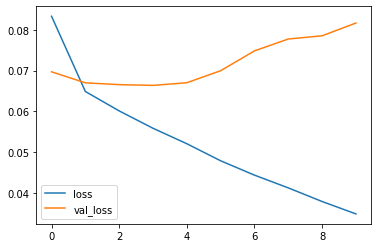

In [71]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

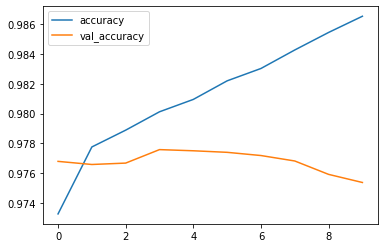

In [74]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [76]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc=roc_auc_score(targets[:, j], p[:, j])
    aucs.append(auc)
print(np.mean(aucs))

0.9848289024548326
